In [ ]:
!gdown --id 1-BuoaHfAHasrSf7mb10N21brUI86rGxs

In [ ]:
!gdown --id 1nuNgS5I2GJpt3KUZQDBOXvZalkMi5krS

In [ ]:
!unzip -o resting-meditators2.zip

In [ ]:
!unzip -o resting-novices.zip

In [ ]:
!pip install -U mne

In [6]:
import mne
import numpy as np
import os
from scipy.signal import hilbert
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

In [7]:
# Define paths
meditators_dir = '/content/resting-meditators2'
novices_dir = '/content/resting-novices'
sfreq = 250

In [8]:
def load_and_prepare_data(directory, montage, notch_freq):
    raws = []
    # Load data
    for filename in os.listdir(directory):
        if filename.endswith('.fif'):
            path = os.path.join(directory, filename)
            # Read the raw file
            raw = mne.io.read_raw_fif(path, preload=True)

            # Apply notch filter to remove power line noise
            raw.notch_filter(notch_freq, filter_length='auto', phase='zero')

            # Apply bandpass filter
            raw.filter(0.5, 45)

            # Crop the data
            raw.crop(tmin=5, tmax=115)

            # Set the montage (electrode positions)
            raw.set_montage(montage)

            raws.append(raw)
    return raws

# Create the standard 10-20 montage
montage = mne.channels.make_standard_montage('standard_1020')

In [ ]:
# Process the meditators and novices data
meditators_raws = load_and_prepare_data(meditators_dir, montage, 50)
novices_raws = load_and_prepare_data(novices_dir, montage, 50)

In [10]:
raw = meditators_raws[0]

Effective window size : 8.192 (s)


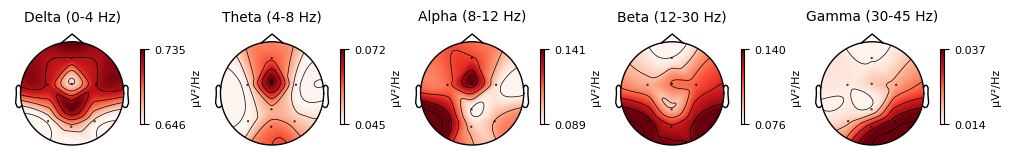

In [11]:
fig = raw.compute_psd().plot_topomap(ch_type='eeg', normalize=True)

Effective window size : 8.192 (s)


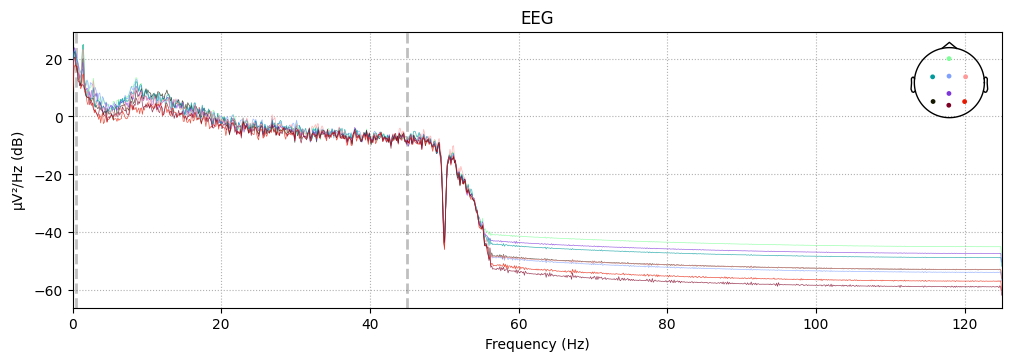

In [12]:
_ = raw.compute_psd().plot()

Using matplotlib as 2D backend.


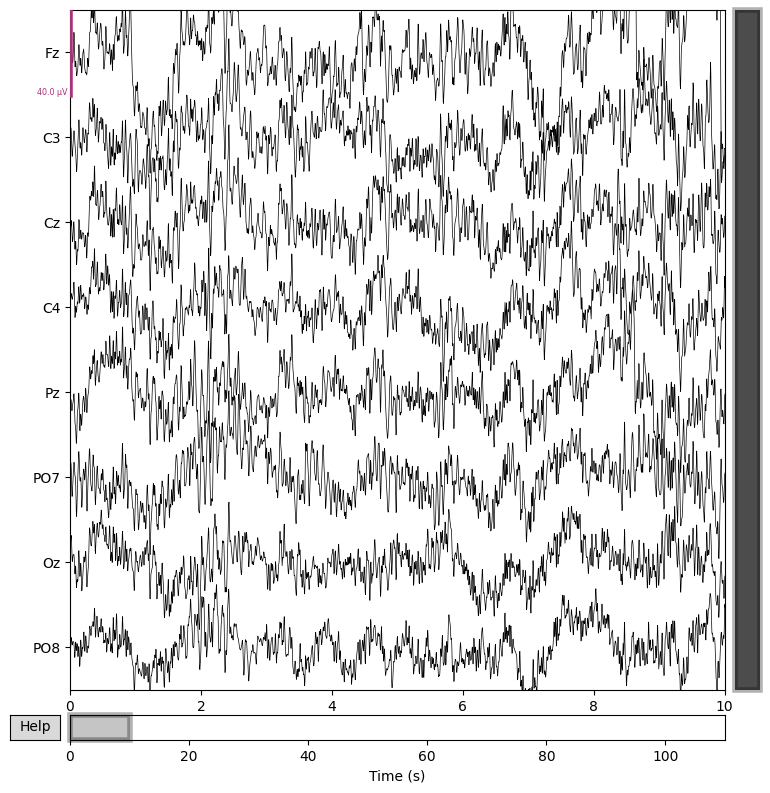

In [13]:
_ = raw.plot()

In [14]:
raw.describe()

<Raw | goenka08-Chantra19-task_resting_state.fif, 8 x 27501 (110.0 s), ~1.7 MB, data loaded>
ch  name  type  unit        min         Q1     median         Q3        max
 0  Fz    EEG   µV       -76.72     -11.07       0.51      11.58      73.32
 1  C3    EEG   µV       -72.15     -10.00       0.81      10.67      78.53
 2  Cz    EEG   µV       -86.38      -7.44      -0.15       7.38      93.43
 3  C4    EEG   µV       -56.49      -8.46       0.56       9.21      58.95
 4  Pz    EEG   µV       -76.14      -8.97       0.06       9.04      73.36
 5  PO7   EEG   µV       -49.58      -7.85      -0.02       7.66      69.58
 6  Oz    EEG   µV       -42.38      -6.00       0.31       6.52      48.68
 7  PO8   EEG   µV       -35.98      -6.08       0.23       6.11      39.03


In [15]:
raw

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.50 Hz
Lowpass,45.00 Hz


# EEG complexity

Step 1: Calculate Complexity Measures for Both Groups

In [ ]:
!pip install nolds

In [17]:
import nolds

def calculate_sampen(raws):
    sampen_values = []
    for raw in raws:
        data = raw.get_data()
        # calculating SampEn for each channel and then averaging
        channel_sampens = [nolds.sampen(data[i]) for i in range(data.shape[0])]
        sampen_values.append(np.mean(channel_sampens))
    return sampen_values


In [18]:
from scipy.stats import ttest_ind, mannwhitneyu

# Calculate complexity measures
meditators_sampen = calculate_sampen(meditators_raws)
novices_sampen = calculate_sampen(novices_raws)

# Check for normality (e.g., using Shapiro-Wilk test) before deciding on the test
# For demonstration, we'll proceed with Mann-Whitney U test as a non-parametric alternative
stat, p_value = mannwhitneyu(meditators_sampen, novices_sampen)

print(f"Mann-Whitney U test Statistic: {stat}, P-value: {p_value}")


Mann-Whitney U test Statistic: 52.0, P-value: 0.9097218891455553


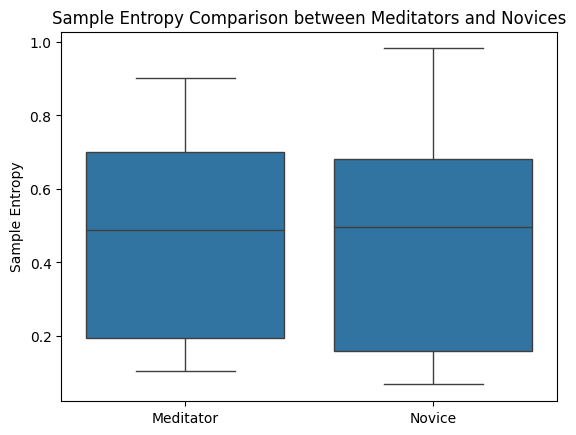

In [19]:
import seaborn as sns

# Combine the sampen values for a unified plot
sampen_values = meditators_sampen + novices_sampen
group_labels = ['Meditator'] * len(meditators_sampen) + ['Novice'] * len(novices_sampen)

sns.boxplot(x=group_labels, y=sampen_values)
plt.title('Sample Entropy Comparison between Meditators and Novices')
plt.ylabel('Sample Entropy')
plt.show()


The p-value is much higher than 0.05, which means that there is no statistically significant difference between the two groups being compared according to the Mann-Whitney U test.